<a href="https://colab.research.google.com/github/martinpius/RNN-ALIENS/blob/main/Multivariate_Time_series_Modeling_(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
try:
  drive.mount("/content/drive/", force_remount = True)
  import tensorflow
  COLAB = True
  print(f"You are on Google Colab with tensorflow version {tensorflow.__version__}")
except:
  COLAB = False
  pass
  

Mounted at /content/drive/
You are on Google Colab with tensorflow version 2.3.0


In [1]:
def time_fmt(x):
  h = int(x/(60*60))
  m = int(x%(60*60)/60)
  s = int(x%60)
  return f"{h}: {m:>03}: {s:>05.2f}"

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import time
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib as mlp
plt.style.use('fivethirtyeight')
%matplotlib inline
from IPython.display import display, Image
from matplotlib.pyplot import imshow

In [ ]:
mlp.rcParams['figure.figsize'] = (10, 8)
mlp.rcParams['axes.grid'] = False

In [ ]:
if COLAB:
  path = "/content/drive/My Drive/energydata_complete.csv"
else:
  pass

In [ ]:
energy = pd.read_csv(path, na_values = ['NA','?'])

In [ ]:
display(energy.head(10))

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.20,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.20,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.20,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.20,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.20,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
5,2016-01-11 17:50:00,50,40,19.890000,46.026667,19.20,44.500000,19.79,44.933333,18.890000,45.730000,17.133333,55.030000,6.300000,85.766667,17.133333,41.260000,18.1,48.590000,17.000000,45.29,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.20,44.500000,19.79,44.900000,18.890000,45.790000,17.100000,54.966667,6.263333,86.090000,17.133333,41.200000,18.1,48.590000,17.000000,45.29,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
7,2016-01-11 18:10:00,60,50,19.856667,45.560000,19.20,44.500000,19.73,44.900000,18.890000,45.863333,17.100000,54.900000,6.190000,86.423333,17.100000,41.200000,18.1,48.590000,17.000000,45.29,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
8,2016-01-11 18:20:00,60,40,19.790000,45.597500,19.20,44.433333,19.73,44.790000,18.890000,45.790000,17.166667,55.000000,6.123333,87.226667,17.166667,41.400000,18.1,48.590000,17.000000,45.29,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702
9,2016-01-11 18:30:00,70,40,19.856667,46.090000,19.23,44.400000,19.79,44.863333,18.890000,46.096667,17.100000,55.000000,6.190000,87.626667,17.200000,41.500000,18.1,48.590000,17.000000,45.29,5.950000,734.300000,91.500000,5.500000,40.000000,4.650000,3.089314,3.089314


In [ ]:
energy.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [ ]:
energy.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [ ]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [ ]:
data = energy.loc[:, ['date','Appliances','lights','RH_2','T_out']]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        19735 non-null  object 
 1   Appliances  19735 non-null  int64  
 2   lights      19735 non-null  int64  
 3   RH_2        19735 non-null  float64
 4   T_out       19735 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 771.0+ KB


In [ ]:
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)

In [ ]:
display(data.head(5))

,date,Appliances,lights,RH_2,T_out
0,2016-01-11 17:00:00,60,30,44.790000,6.600000
1,2016-01-11 17:10:00,60,30,44.722500,6.483333
2,2016-01-11 17:20:00,50,30,44.626667,6.366667
3,2016-01-11 17:30:00,50,40,44.590000,6.250000
4,2016-01-11 17:40:00,60,40,44.530000,6.133333


In [ ]:
display(data.tail(5))

,date,Appliances,lights,RH_2,T_out
19730,2016-05-27 17:20:00,100,0,42.025714,22.733333
19731,2016-05-27 17:30:00,90,0,42.080000,22.600000
19732,2016-05-27 17:40:00,270,10,42.768571,22.466667
19733,2016-05-27 17:50:00,420,10,43.036000,22.333333
19734,2016-05-27 18:00:00,430,10,42.971429,22.200000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f715ec4db70>,
      dtype=object)

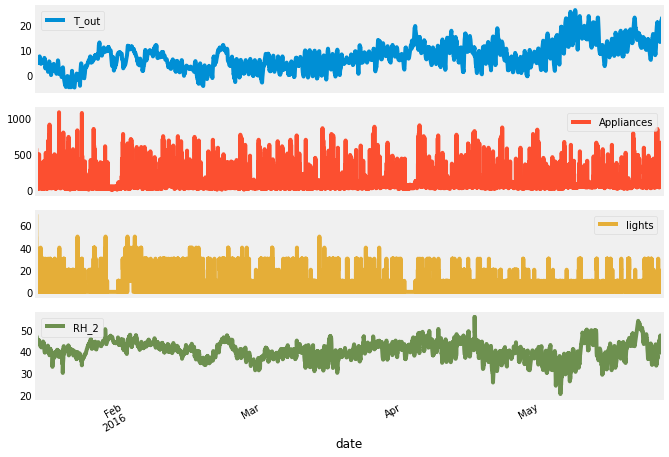

In [ ]:
data.set_index('date')[['T_out','Appliances','lights','RH_2']].plot(subplots = True)

In [ ]:
x = data[['Appliances','T_out','RH_2']]
y = data['Appliances']

In [ ]:
x = x.to_numpy().tolist()
y = y.tolist()

In [ ]:
x[0:10]

[[60.0, 6.6, 44.79],
 [60.0, 6.48333333333333, 44.7225],
 [50.0, 6.36666666666667, 44.6266666666667],
 [50.0, 6.25, 44.59],
 [60.0, 6.133333333333329, 44.53],
 [50.0, 6.01666666666667, 44.5],
 [60.0, 5.9, 44.5],
 [60.0, 5.91666666666667, 44.5],
 [60.0, 5.93333333333333, 44.4333333333333],
 [70.0, 5.95, 44.4]]

In [ ]:
y[0:10]

[60, 60, 50, 50, 60, 50, 60, 60, 60, 70]

In [ ]:
tsgen = TimeseriesGenerator(x, y, length=6, sampling_rate=1, batch_size=1)

In [ ]:
tsgen[0]

(array([[[60.        ,  6.6       , 44.79      ],
         [60.        ,  6.48333333, 44.7225    ],
         [50.        ,  6.36666667, 44.62666667],
         [50.        ,  6.25      , 44.59      ],
         [60.        ,  6.13333333, 44.53      ],
         [50.        ,  6.01666667, 44.5       ]]]), array([60]))

In [ ]:
tsgen[0][0][0]

array([[60.        ,  6.6       , 44.79      ],
       [60.        ,  6.48333333, 44.7225    ],
       [50.        ,  6.36666667, 44.62666667],
       [50.        ,  6.25      , 44.59      ],
       [60.        ,  6.13333333, 44.53      ],
       [50.        ,  6.01666667, 44.5       ]])

In [ ]:
tsgen[1]

(array([[[60.        ,  6.48333333, 44.7225    ],
         [50.        ,  6.36666667, 44.62666667],
         [50.        ,  6.25      , 44.59      ],
         [60.        ,  6.13333333, 44.53      ],
         [50.        ,  6.01666667, 44.5       ],
         [60.        ,  5.9       , 44.5       ]]]), array([60]))